# Mine Production Planning with Stockpiling (with Gurobi)

## Introduction
Open-pit mine production scheduling is a central planning task in mining operations. The goal is to decide **when and how much material to extract and process** from different blocks of the mine, over a finite time horizon, in order to maximize the economic value of the project. Traditionally, this is formulated as the **Open Pit Mine Production Scheduling Problem (OPMPSP)**, which already is a large-scale mixed-integer optimization problem due to precedence constraints among blocks, mining and processing capacity limits, and economic discounting.

In practice, mining operations often make use of **stockpiles**: mined ore that is not immediately processed can be stored and reclaimed later. This flexibility allows the mine to adapt to fluctuations in ore quality and market conditions, increasing overall Net Present Value (NPV). However, the introduction of stockpiles complicates the optimization model: once material is placed into a stockpile, it is mixed homogeneously with existing material, and when it is reclaimed, the quality corresponds to the **average composition** of the stockpile. Mathematically, this leads to **bilinear (quadratic) constraints**, which are computationally challenging for standard MILP solvers.

The paper by [Bley, Boland, Froyland, and Zuckerberg (2012)](https://web.maths.unsw.edu.au/~froyland/bbfz.pdf) develops advanced formulations (Natural, Aggregated, and Discretized models) to handle stockpile effects within an optimization framework. Their results show that carefully designed extended formulations and branching strategies yield much tighter relaxations and practical solvability compared to naive models.


## Problem Description
We consider the **Open Pit Mine Production Scheduling Problem with Stockpiling (OPMPSP+S).**

## Sets
- $T = \{1,\dots,|T|\}$ : set of time periods  
- $N = \{1,\dots,|N|\}$ : set of blocks (aggregates)  
- $P(i) \subseteq N$ : set of immediate predecessors of block $i$  

## Parameters
- $R_i$ : rock tonnage of block $i$ [t]  
- $O_i$ : ore tonnage of block $i$ [t]  
- $A_i$ : metal tonnage in block $i$ [t]  
- $c$ : sales price of metal [\$/t metal] (or time-dependent $c_t$)  
- $m$ : mining cost per tonne rock [\$/t]  
- $p$ : processing cost per tonne ore [\$/t]  
- $M_t$ : mining capacity in period $t$ [t rock]  
- $P_t$ : processing capacity in period $t$ [t ore]  
- $\delta_t$ : discount factor for period $t$  

## Decision Variables
- $x_{i,t} \in \{0,1\}$: 1 if block $i$ has been completely mined by the end of time period $t$
- $y_{i,t} \in [0,1]$: is the fraction of block $i$ mined during time period $t$
- $z_{i,t}^p \in [0,1]$: is the fraction of block $i$ sent directly for processing in period $t$
- $z_{i,t}^s \in [0,1]$: is the fraction of block $i$ sent to stockpile in time period $t$
- $y_{i,t} - z_{i,t}^p - z_{i,t}^s$: is the fraction of block $i$ that is sent to waste dump in period $t$
- $o_{t}^p$: is the total amount of **ore** sent from the stockpile to the processing plant during time period $t$
- $a_{t}^p$: is the total amount of **metal** sent from the stockpile to the processing plant during time period $t$
- $o_{t}^s$: is the total amount of **ore** remaining in the stockpile during time period $t$
- $a_{t}^s$: is the total amount of **metal** remaining in the stockpile during time period $t$

---

## Objective

$$
\max \; \sum_{t=1}^T \delta_t \Bigg(
c \Big( a_t^p + \sum_{i=1}^N A_i \,z_{i,t}^p\Big)
- p \Big( o_t^p + \sum_{i=1}^N O_i \, z_{i,t}^p \Big)
- m \Big( \sum_{i=1}^N R_i \, y_{i,t}\Big)
\Bigg)
$$

---

## Constraints

**cumulative mining formulation**
$$
x_{i,t-1} \;\leq\; x_{i,t}
\quad \forall i \in N, t \in \{2,\dots, T\}
$$


**link x and y**
$$
x_{i,t} \;\leq\; \sum_{\tau=1}^{t} y_{i,\tau}
\quad \forall i \in N, \forall t \in T
$$

**Ensure total mined fraction <= 1**

$$
\sum_{t=1}^{T} y_{i,t} \;\leq\; 1 
\quad \forall i \in N
$$


**Precedence constraints**
$$
\sum_{\tau=1}^{T} y_{i,\tau} \;\leq\; x_{j,t}
\quad \forall i \in N, \; j \in P(i), \; \forall t \in T
$$

**Processing vs. stockpiling decision**  

$$
z_{i,t}^p + z_{i,t}^s \;\leq\; y_{i,t}
\quad \forall i \in N,\; \forall t \in T
$$

**Stockpile dynamics**

- For $t=1$:
$$
o_1^s = o_1^p = o_T^s = a_1^s = a_1^p = a_T^s = 0
$$
- For $t > 1$:
$$ 
o_{t-1}^s + \sum_{i=1}^N O_i \, z_{i,t-1}^s = o_t^s + o_t^p 
\quad \forall t \in \{2,\ldots, T\}
$$
$$ 
a_{t-1}^s + \sum_{i=1}^N A_i \, z_{i,t-1}^s = a_t^s + a_t^p 
\quad \forall t \in \{2,\ldots, T\}
$$ 

**Mining capacity**

$$
\sum_{i=1}^N R_i \, y_{i,t} \;\leq\; M_t 
\quad \forall t \in T
$$

**Processing capacity**

$$
\sum_{i=1}^N O_i \, z_{i,t}^p + o_t^p \;\leq\; P_t 
\quad \forall t \in T
$$


**Stockpile quality (bilinear)**

$$
a_t^p(o_t^s + o_t^p) = o_t^p(a_t^s + a_t^p)
\quad \forall t \in T
$$  




In the paper, the model is presented in a general form without a concrete numerical example. In this notebook, we apply the model to the following practical case.

### Example

We consider a small mine with **5 blocks** to be scheduled over **3 time periods**. Each block is characterized by its rock tonnage, ore tonnage, and metal content, together with precedence constraints that specify the mining order. In each time period, mining and processing capacities limit how much material can be extracted and treated. In addition, a stockpile is available, allowing material to be stored for later processing, but subject to the homogeneous-mixing quality constraint.  

This small dataset allows us to illustrate the full model formulation, decision variables, and constraints in action, and to show how the optimization can be solved using `Gurobi`.


In [3]:
import gurobipy as gp
from gurobipy import GRB, quicksum
from itertools import product
from gurobipy import multidict, tuplelist
import pandas as pd
import numpy as np
from graphviz import Digraph
from optutils import gurobi_helpers, plotting
from optutils.plotting import draw_problem
from optutils.gurobi_helpers import (define_variables, define_objective, delta, define_constraints)

### Define data
Now, we define the data used in our example.

In [6]:
# interest rate
q = 0.10  

# scalar costs / global (time-invariant)
m = 2.0               # mining cost per tonne of rock
proc_cost = 5.0       # processing cost per tonne of ore
c = 100.0             # sales price per tonne of metal


# Define time periods with [mining_capacity, processing_capacity]
time_periods, mining_capacity, processing_capacity, discount_factor = multidict({
    t: [mc, pc, delta(t, q)]
    for t, (mc, pc) in {
        1: (15, 10),  # Period 1: 15 tonnes mining cap, 10 tonnes processing cap
        2: (15, 10),  # Period 2: same as above
        3: (15, 10)   # Period 3: same as above
    }.items()
})


# Define blocks with [rock_tonnage, ore_tonnage, metal_tonnage]
blocks, R, O, A = multidict({
    1: [10, 10, 8.0],   # Block 1: high grade (80%)
    2: [10, 10, 6.0],   # Block 2: medium grade (60%)
    3: [15, 15, 4.5],   # Block 3: lower grade (30%)
    4: [10, 10, 5.0],   # Block 4: 50% grade
    5: [8,  8,  1.6]    # Block 5: low grade (20%)
})

# Define plants for processing to extract the metal from the rock
plants = ["P"]

# Define stockpiles 
stockpiles = ["S"]

# Define waste dumps
waste_dumps = ["W"]

# Define precedence constraints (i must be mined before j)
P = {3 : {1, 2}, 4: {3}, 5: {3, 4}}


In [52]:
# --- Helper ---

# block period composition (i.e. x_{i,t} variables)
#block_periods = tuplelist([(block, period) for block in blocks for period in periods])
block_periods = tuplelist(product(blocks, time_periods))
block_periods_plants = tuplelist(product(blocks, time_periods, plants))
block_periods_stockpiles = tuplelist(product(blocks, time_periods, stockpiles))
block_periods_waste_dumps = tuplelist(product(blocks, time_periods, waste_dumps))
plants_stockpiles_periods = tuplelist(product(plants, stockpiles, time_periods))
stockpile_periods = tuplelist(product(stockpiles, time_periods))
block_periods_stockpiles_plants = tuplelist(product(blocks, time_periods, stockpiles, plants))

### Visualising the problem

We can draw a directed graph with `graphviz` package to visulise the problem.

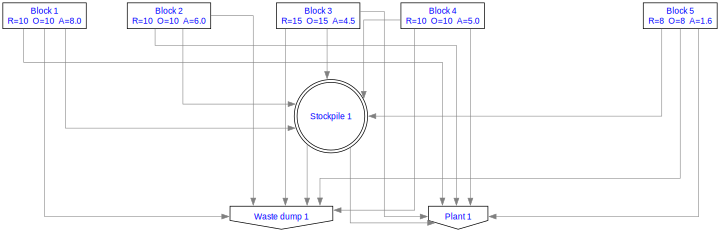

In [5]:
draw_problem(blocks=blocks, 
             stockpiles=stockpiles, 
             plants=plants, 
             waste_dumps=waste_dumps,
             R=R,
             O=O,
             A=A)

### (1) Model Deployment (Natural Formulation $S_{[NF]}$)

We create a model and the variables. Solving quadratic assignment problems  with Gurobi is as easy as configuring the global parameter `nonConvex`, and setting this parameter to the value of 2.

In [8]:
model_NF = gp.Model('MineProductionPlanningNF')

# set global parameters
model_NF.params.nonConvex = 2

Set parameter Username
Set parameter LicenseID to value 2588857
Academic license - for non-commercial use only - expires 2025-11-22
Set parameter NonConvex to value 2


In [12]:
# Define decision variables with define_variables with set x_binary to True and aggregate to False
x, y, z_p, z_s, oreSP, oreS_rem, metalSP, metalS_rem = define_variables(model_NF, blocks ,
                                                                        time_periods, plants,
                                                                        stockpiles, waste_dumps,
                                                                        x_binary=True, aggregate = False)

# Define objective function with define_objective_NF
define_objective(model_NF, y, z_p, oreSP, metalSP, blocks, plants, stockpiles, time_periods,
                   O, A, R, c, proc_cost, m, q)

# Define constraints with define_constraints with set enforce_mixing=True
define_constraints(model_NF, x, y, z_p, z_s,
                   oreS_rem, metalS_rem, oreSP, metalSP,
                   blocks, plants, stockpiles, time_periods,
                   O, A, R, P,
                   mining_capacity,processing_capacity,
                   enforce_mixing=True,aggregate=False, enforce_mixing_aggregate=False)

Set parameter NonConvex to value 2


In [14]:
model_NF.write('../models/MineProductionPlanning_NF_with_gurobi.lp')    # model saved

model_NF.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 76 rows, 72 columns and 241 nonzeros
Model fingerprint: 0xa415907f
Model has 3 quadratic constraints
Variable types: 57 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 42 rows and 38 columns
Presolve time: 0.00s
Presolved: 43 rows, 37 columns, 119 nonzeros
Presolved model has 2 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 31 continuous, 6 integer (6 binary)
Found heuristic solution: objective 1101.6528959

Root relaxation: o

### Analysis

**1. x & y Output Report**

In [13]:
periods = sorted(time_periods)
blocks_list = sorted(blocks)
plants_list = sorted(plants)
stockpiles_list = sorted(stockpiles)

rows = []
for i in blocks_list:
    for t in periods:
        rows.append({
            "Block": i,
            "Period": t,
            "x": x[i, t].X,
            "y": f"{y[i, t].X:.2f}"
        })

x_y_report = pd.DataFrame(rows).sort_values(["Block", "Period"])
x_y_report.index = [''] * len(x_y_report)
# x_y_report

**2. Periodic Summary**

In [16]:
period_rows = []
for t in time_periods:
    # mined rock in this period
    mined_rock_t = sum(R[i] * y[i, t].X for i in blocks_list)

    # direct-to-plant ore/metal in this period
    direct_ore_t = sum(O[i] * sum(z_p[i, t, p].X for p in plants_list) for i in blocks_list)
    direct_metal_t = sum(A[i] * sum(z_p[i, t, p].X for p in plants_list) for i in blocks_list)

    # reclaimed from stockpile in this period (aggregated over all s and p)
    reclaim_ore_t = sum(oreSP[p, s, t].X for p in plants_list for s in stockpiles_list)
    reclaim_metal_t = sum(metalSP[p, s, t].X for p in plants_list for s in stockpiles_list)

    # stockpile end-of-period inventories (aggregated)
    ore_stock_t = sum(oreS_rem[s, t].X for s in stockpiles_list)
    metal_stock_t = sum(metalS_rem[s, t].X for s in stockpiles_list)

    period_rows.append({
        "period": t,
        "mined_rock": mined_rock_t,
        "direct_ore": direct_ore_t,
        "reclaim_ore": reclaim_ore_t,
        "total_ore_to_plant": direct_ore_t + reclaim_ore_t,
        "direct_metal": direct_metal_t,
        "reclaim_metal": reclaim_metal_t,
        "total_metal_to_plant": direct_metal_t + reclaim_metal_t,
        "ore_stock_end": ore_stock_t,
        "metal_stock_end": metal_stock_t,
        "mining_cap": mining_capacity[t],
        "processing_cap": processing_capacity[t],
    })
period_summary = pd.DataFrame(period_rows)
period_summary.index = [''] * len(period_summary)
#period_summary

**3. Display Output**

In [19]:
with pd.option_context("display.float_format", "{:,.3f}".format):
    print("\n===== x & y Output Report =====")
    display(x_y_report)
    print("\n===== Periodic Summary =====")
    display(period_summary)


===== x & y Output Report =====


,Block,Period,x,y
,1,1,0.000,1.00
,1,2,1.000,0.00
,1,3,1.000,0.00
,2,1,0.000,0.50
,2,2,1.000,0.50
,2,3,1.000,0.00
,3,1,0.000,0.00
,3,2,0.000,0.67
,3,3,1.000,0.33
,4,1,0.000,0.00



===== Periodic Summary =====


,period,mined_rock,direct_ore,reclaim_ore,total_ore_to_plant,direct_metal,reclaim_metal,total_metal_to_plant,ore_stock_end,metal_stock_end,mining_cap,processing_cap
,1,15.000,10.000,0.000,10.000,8.000,0.000,8.000,0.000,0.000,15,10
,2,15.000,5.000,5.000,10.000,3.000,3.000,6.000,0.000,0.000,15,10
,3,15.000,10.000,0.000,10.000,5.000,0.000,5.000,0.000,0.000,15,10


### (2) Model Deployment (Mixed-Integer Linear Relaxation $S_{[NF-IP]}$)

We extend the NF model by relaxing its bilinear constraints (11).

### Define Model

In [22]:
model_NF_IP = gp.Model('MineProductionPlanningNF-IP')

# set global parameters
#model_NF_IP.params.nonConvex = 2

In [24]:
# Define decision variables with define_variables with set x_binary to True and aggregate to False
x, y, z_p, z_s, oreSP, oreS_rem, metalSP, metalS_rem = define_variables(model_NF_IP, blocks ,
                                                                        time_periods, plants,
                                                                        stockpiles, waste_dumps,
                                                                        x_binary=True, aggregate=False)

# Define objective function with define_objective_NF
define_objective(model_NF_IP, y, z_p, oreSP, metalSP, blocks, plants, stockpiles, time_periods,
                   O, A, R, c, proc_cost, m, q)

# Define constraints with define_constraints with set enforce_mixing=False
define_constraints(model_NF_IP, x, y, z_p, z_s,
                   oreS_rem, metalS_rem, oreSP, metalSP,
                   blocks, plants, stockpiles, time_periods,
                   O, A, R, P,
                   mining_capacity,processing_capacity,
                   enforce_mixing=False,aggregate=False, enforce_mixing_aggregate=False)

In [26]:
model_NF_IP.write('../models/MineProductionPlanning_NF_IP_with_gurobi.lp')    # model saved

model_NF_IP.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 76 rows, 72 columns and 241 nonzeros
Model fingerprint: 0x144a60f6
Variable types: 57 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 43 rows and 40 columns
Presolve time: 0.00s
Presolved: 33 rows, 32 columns, 97 nonzeros
Variable types: 26 continuous, 6 integer (6 binary)

Root relaxation: objective 1.399850e+03, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0 

### (3) Model Deployment (Linear Relaxation $S_{[NF-LP]}$)

We extend the NF model by relaxing its bilinear constraints (11) and by dropping the integrality constraints from (NF)-version.

### Define Model

In [34]:
model_NF_LP = gp.Model('MineProductionPlanningNF-LP')

# set global parameters
#model.params.nonConvex = 2

In [36]:
# Define decision variables with define_variables with set x_binary to False and aggregate to False
x, y, z_p, z_s, oreSP, oreS_rem, metalSP, metalS_rem = define_variables(model_NF_LP, blocks ,
                                                                        time_periods, plants,
                                                                        stockpiles, waste_dumps,
                                                                        x_binary=False, aggregate=False)

# Define objective function with define_objective_NF
define_objective(model_NF_LP, y, z_p, oreSP, metalSP, blocks, plants, stockpiles, time_periods,
                   O, A, R, c, proc_cost, m, q)

# Define constraints with define_constraints with set enforce_mixing=False
define_constraints(model_NF_LP, x, y, z_p, z_s,
                   oreS_rem, metalS_rem, oreSP, metalSP,
                   blocks, plants, stockpiles, time_periods,
                   O, A, R, P,
                   mining_capacity,processing_capacity,
                   enforce_mixing=False,aggregate=False, enforce_mixing_aggregate=False)

In [38]:
model_NF_LP.write('../models/MineProductionPlanning_NF_LP_with_gurobi.lp')    # model saved

model_NF_LP.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 76 rows, 72 columns and 241 nonzeros
Model fingerprint: 0x21a44fc5
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 19 rows and 23 columns
Presolve time: 0.01s
Presolved: 57 rows, 49 columns, 191 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8779611e+03   8.736517e+01   0.000000e+00      0s
      19    1.4148760e+03   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.414876033e+03


## Stronger Formulations

### (1) Aggregate Tracking Model (AT)

In the (NF) formulation the material from all aggregates sent from the pit to the stockpile is aggregated into variables $o^s$ and $a^s$, which only describe the total $ore$ and $metal$ content of the stockpile. Alternatively, we may track the material flow through the stockpile at an individual
aggregate level. For this, we introduce for each aggregate $i$ and time period $t$ the additional variables $z_{i,t}^{s,p}$ and $z_{i,t}^{s,s}$ in the following way:

### Define model

In [7]:
model_AT = gp.Model('MineProductionPlanningAT')

# set global parameters
model_AT.params.nonConvex = 2

Set parameter Username
Set parameter LicenseID to value 2588857
Academic license - for non-commercial use only - expires 2025-11-22
Set parameter NonConvex to value 2


In [9]:
# Define decision variables with define_variables with x is set to binary
x, y, z_p, z_s, oreSP, oreS_rem, metalSP, metalS_rem, z_ss, z_sp, f_t = define_variables(model_AT,
                                                                                            blocks,
                                                                                            time_periods,
                                                                                            plants,
                                                                                            stockpiles,
                                                                                            waste_dumps,
                                                                                            x_binary = True,
                                                                                            aggregate = True
                                                                                           )

# Define objective function with define_objective
define_objective(model_AT, y, z_p, oreSP, metalSP, blocks, plants, stockpiles, time_periods, O, A, R, c, proc_cost, m, q)

# Define constraints with define_constraints with set enforce_mixing=False
define_constraints(model_AT, x, y, z_p, z_s,
                      oreS_rem, metalS_rem, oreSP, metalSP,
                      z_ss, z_sp, f_t,
                      blocks, plants, stockpiles, time_periods,
                      O, A, R, P,mining_capacity,processing_capacity,
                      enforce_mixing=False,aggregate=True, enforce_mixing_aggregate=True)

In [11]:
model_AT.write('../models/MineProductionPlanning_AT_with_gurobi.lp')    # model saved

model_AT.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 113 rows, 105 columns and 368 nonzeros
Model fingerprint: 0x49e41c09
Model has 15 quadratic constraints
Variable types: 90 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 77 rows and 68 columns
Presolve time: 0.00s
Presolved: 66 rows, 42 columns, 159 nonzeros
Presolved model has 7 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 36 continuous, 6 integer (6 binary)
Found heuristic solution: objec

### (2) Model Deployment (Mixed-Integer Linear Relaxation $S_{[AT-IP]}$)

We extend the AT model by relaxing its bilinear constraints (18).

#### Define Model

In [13]:
model_AT_IP = gp.Model('MineProductionPlanningAT_IP')

# set global parameters
model_AT_IP.params.nonConvex = 2

Set parameter NonConvex to value 2


In [15]:
# Define decision variables with define_variables with x is set to binary
x, y, z_p, z_s, oreSP, oreS_rem, metalSP, metalS_rem, z_ss, z_sp, f_t = define_variables(model_AT_IP,
                                                                                            blocks,
                                                                                            time_periods,
                                                                                            plants,
                                                                                            stockpiles,
                                                                                            waste_dumps,
                                                                                            x_binary = True,
                                                                                            aggregate = True
                                                                                           )

# Define objective function with define_objective
define_objective(model_AT_IP, y, z_p, oreSP, metalSP, blocks, plants, stockpiles, time_periods, O, A, R, c, proc_cost, m, q)

# Define constraints with define_constraints with set enforce_mixing=False
define_constraints(model_AT_IP, x, y, z_p, z_s,
                      oreS_rem, metalS_rem, oreSP, metalSP,
                      z_ss, z_sp, f_t,
                      blocks, plants, stockpiles, time_periods,
                      O, A, R, P,mining_capacity,processing_capacity,
                      enforce_mixing=False,aggregate=True, enforce_mixing_aggregate=False)

In [17]:
model_AT_IP.write('../models/MineProductionPlanning_AT_IP_with_gurobi.lp')    # model saved

model_AT_IP.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 113 rows, 105 columns and 368 nonzeros
Model fingerprint: 0xca5d9b4c
Variable types: 90 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 81 rows and 73 columns
Presolve time: 0.00s
Presolved: 32 rows, 32 columns, 97 nonzeros
Variable types: 26 continuous, 6 integer (6 binary)

Root relaxation: objective 1.399850e+03, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent

### (3) Model Deployment (Linear Relaxation $S_{[AT-LP]}$)

We extend the NF model by relaxing its bilinear constraints (18) and by dropping the integrality constraints from (AT)-version.

#### Define Model

In [19]:
model_AT_LP = gp.Model('MineProductionPlanningAT_LP')

# set global parameters
#model_AT_LP.params.nonConvex = 2

In [21]:
# Define decision variables with define_variables with x is set to continuous
x, y, z_p, z_s, oreSP, oreS_rem, metalSP, metalS_rem, z_ss, z_sp, f_t = define_variables(model_AT_LP,
                                                                                            blocks,
                                                                                            time_periods,
                                                                                            plants,
                                                                                            stockpiles,
                                                                                            waste_dumps,
                                                                                            x_binary = False,
                                                                                            aggregate = True
                                                                                           )

# Define objective function with define_objective
define_objective(model_AT_LP, y, z_p, oreSP, metalSP, blocks, plants, stockpiles, time_periods, O, A, R, c, proc_cost, m, q)

# Define constraints with define_constraints with set enforce_mixing=False
define_constraints(model_AT_LP, x, y, z_p, z_s,
                      oreS_rem, metalS_rem, oreSP, metalSP,
                      z_ss, z_sp, f_t,
                      blocks, plants, stockpiles, time_periods,
                      O, A, R, P,mining_capacity,processing_capacity,
                      enforce_mixing=False,aggregate=True, enforce_mixing_aggregate=False)

In [23]:
model_AT_LP.write('../models/MineProductionPlanning_AT_LP_with_gurobi.lp')    # model saved

model_AT_LP.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 113 rows, 105 columns and 368 nonzeros
Model fingerprint: 0xae568b52
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 56 rows and 52 columns
Presolve time: 0.01s
Presolved: 57 rows, 53 columns, 199 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5652091e+03   8.156100e+01   0.000000e+00      0s
      21    1.3998497e+03   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.399849737e+03


### (2) Discretised Out-Fraction